# 3.1 MNIST

In [1]:
from shutil import copyfileobj
from six.moves import urllib
from sklearn.datasets.base import get_data_home
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def fetch_mnist(data_home=None):
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    data_home = get_data_home(data_home=data_home)
    data_home = os.path.join(data_home, 'mldata')
    if not os.path.exists(data_home):
        os.makedirs(data_home)
    mnist_save_path = os.path.join(data_home, "mnist-original.mat")
    if not os.path.exists(mnist_save_path):
        mnist_url = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_save_path, "wb") as matlab_file:
            copyfileobj(mnist_url, matlab_file)

In [2]:
fetch_mnist()

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

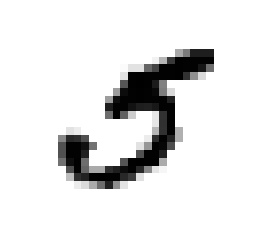

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [8]:
y[36000]

5.0

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 3.2 이진 분류기 훈련

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

# 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9656 , 0.96525, 0.9577 ])

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9119 , 0.90755, 0.9095 ])

### 3.3.2 오차 행렬
분류기의 성능을 평가하는 더 좋은 방법은 **오차 행렬**(confusion matrix)을 조사하는 것이다.

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53901,   678],
       [ 1551,  3870]])

In [19]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 3.3.3 정밀도와 재현율

In [20]:
from sklearn.metrics import precision_score, recall_score

In [21]:
precision_score(y_train_5, y_train_pred)

0.8509234828496042

In [22]:
recall_score(y_train_5, y_train_pred)

0.7138904261206419

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7764068612699367

### 3.3.4 정밀도/재현율 트레이드오프
SGDClassifier 분류기는 **결정 함수**(decision function)을 사용하여 각 샘플의 점수를 계산한다. 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고, 그렇지 않으면 음성 클래스에 할당한다.

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([117456.88919851])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [26]:
y_some_digit_pred

array([ True])

In [27]:
threshold = 20000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [29]:
y_scores.shape

(60000,)

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

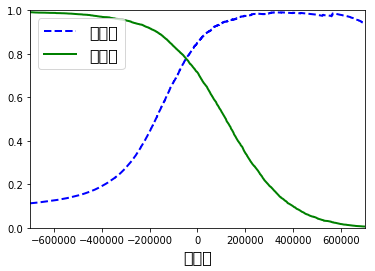

In [32]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [33]:
(y_train_pred == (y_scores > 0)).all()

True

In [34]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

0.9247467438494935

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.5893746541228556

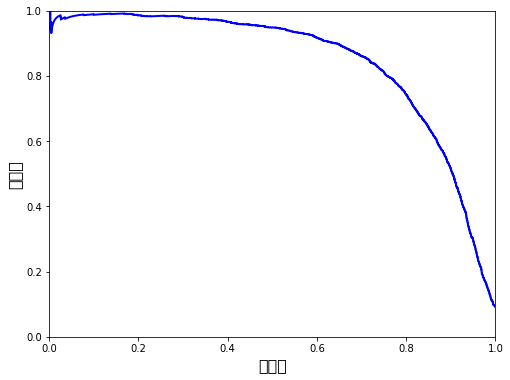

In [36]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("재현율", fontsize=16)
    plt.ylabel("정밀도", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# 3.3.5 ROC 곡선
ROC(Receiver Operating Characteristic)은 이진 분류에서 널리 사용되는 도구이다. 정밀도/재현율 곡선과 매우 비슷하지만, ROC 곡선은 정밀도에 대한 재현율 곡선이 아니고 **거짓 양성 비율**(FPR, False Positive Rate)에 대한 **진짜 양성 비율**(TPR, True Positive Rate)의 곡선이다.

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

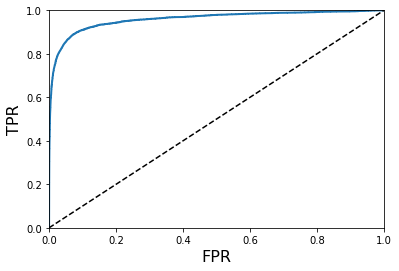

In [38]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)

plot_roc_curve(fpr, tpr)
plt.show()

여기에는 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어나는 트레이드오프가 있다. 점선은 완전한 랜덤 분류기의 ROC 곡선이다. 좋은 분류기는 이 점선으로부터 최대한 멀리 떨어져 있어야 한다(왼쪽 모서리).

**곡선 아래의 면적**(AUC, Area Under the Curve)을 측정하면 분류기들을 비교할 수 있다. 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5이다.

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9592634988069312

In [40]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [41]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

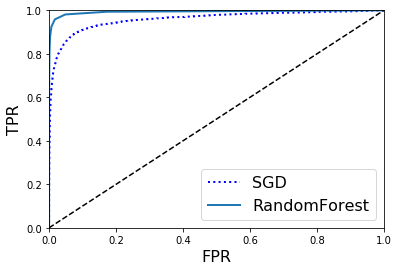

In [42]:
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [43]:
roc_auc_score(y_train_5, y_scores_forest)

0.9932577284007413

# 3.4 다중 분류

In [44]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [45]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-175507.36137534, -408561.71510398, -541097.07965745,
        -236424.2953346 , -378521.65450607,  117456.88919851,
        -837650.399884  , -335594.83120349, -768456.46456404,
        -672999.73999527]])

In [46]:
np.argmax(some_digit_scores)

5

In [47]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [48]:
sgd_clf.classes_[5]

5.0

In [49]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [50]:
len(ovo_clf.estimators_)

45

In [51]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [52]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.1, 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86782643, 0.86719336, 0.86853028])

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90856829, 0.90949547, 0.9086363 ])

# 3.5 에러 분석

In [55]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5723,    3,   18,    7,   12,   55,   49,    9,   42,    5],
       [   2, 6487,   41,   25,    6,   42,    7,    8,  111,   13],
       [  51,   38, 5327,   96,   88,   27,   87,   61,  167,   16],
       [  50,   39,  147, 5311,    2,  259,   38,   55,  131,   99],
       [  17,   29,   32,    8, 5358,    7,   56,   29,   75,  231],
       [  72,   43,   35,  184,   72, 4618,  114,   25,  164,   94],
       [  32,   26,   45,    1,   44,   88, 5628,   10,   44,    0],
       [  23,   25,   67,   32,   62,   10,    6, 5787,   18,  235],
       [  51,  162,   68,  147,   16,  164,   60,   27, 5000,  156],
       [  46,   35,   28,   89,  159,   34,    3,  198,   62, 5295]])

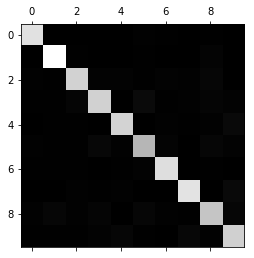

In [56]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

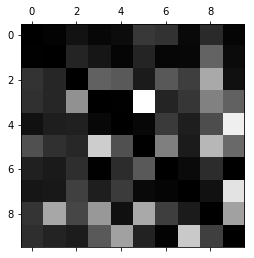

In [58]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

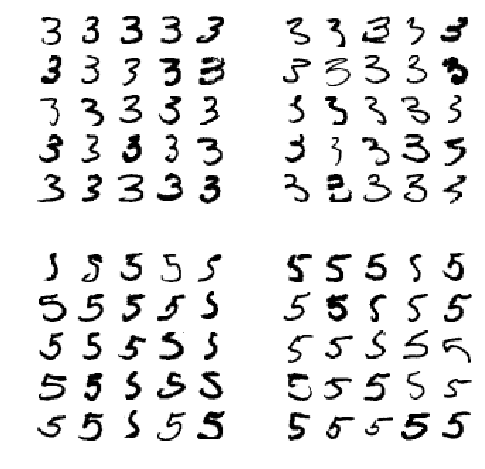

In [59]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 3.6 다중 레이블 분류

In [60]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [61]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 3.7 다중 출력 분류

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)